# License Plate Recognition

Datenset für das Training der OCR-Erkennung

### Importing Packages

In [1]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from scipy import misc
from skimage import data
import glob
import shutil

print ("TensorFlow Version: {}".format(tf.__version__))

TensorFlow Version: 2.1.0-rc1


#### Training Parameter

In [2]:
data_path = "D:/development/tensorflow/datasets/alpr"

classes=['plates']

BATCH_SIZE = 100
NUM_EPOCHS = 100

IMAGE_WIDTH = 128
IMAGE_HEIGHT = 44

POOL_SIZE = 2
MAX_TEXT_LEN = 10

OPTIMIZER = "adagrad"

OUTPUT_PATH = 'output'
MODEL_NAME = "alpr.model"

### Data Loading

In [3]:
from pyimagesearch.io import Hdf5DatasetLoader
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split

loader = Hdf5DatasetLoader()
images, labels = loader.load(data_path + '/hdf5/train.h5', shuffle=True)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [5]:
from pyimagesearch.io import Hdf5DatasetLoader
from license_plate_image_augmentor import LicensePlateImageAugmentor
from licence_plate_dataset_generator import LicensePlateDatasetGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
import skimage

#loader = Hdf5DatasetLoader()
#images, labels = loader.load(data_path + '/hdf5/train.h5', shuffle=True)
#images = np.expand_dims(images, axis=-1)
#print (images.shape)

#X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=[0.8, 2.8],
    shear_range=2.5,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    horizontal_flip=False,
    validation_split=0.2)

#images, labels = next(data_gen.flow(X_train, y_train, batch_size=BATCH_SIZE))
#images = [skimage.transform.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH)) for image in images]

def plotImages(images_arr, labels, rows, columns):
    fig, axes = plt.subplots(rows, columns, figsize=(50,50))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels, axes):
        img = img.reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
        ax.set_title(label)
        ax.imshow(img, cmap='gray')
    plt.tight_layout()
    plt.show()
    
#plotImages(images, labels, int(BATCH_SIZE / 4), 4)

C:\Users\Andreas\Anaconda3\envs\dl4cv\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


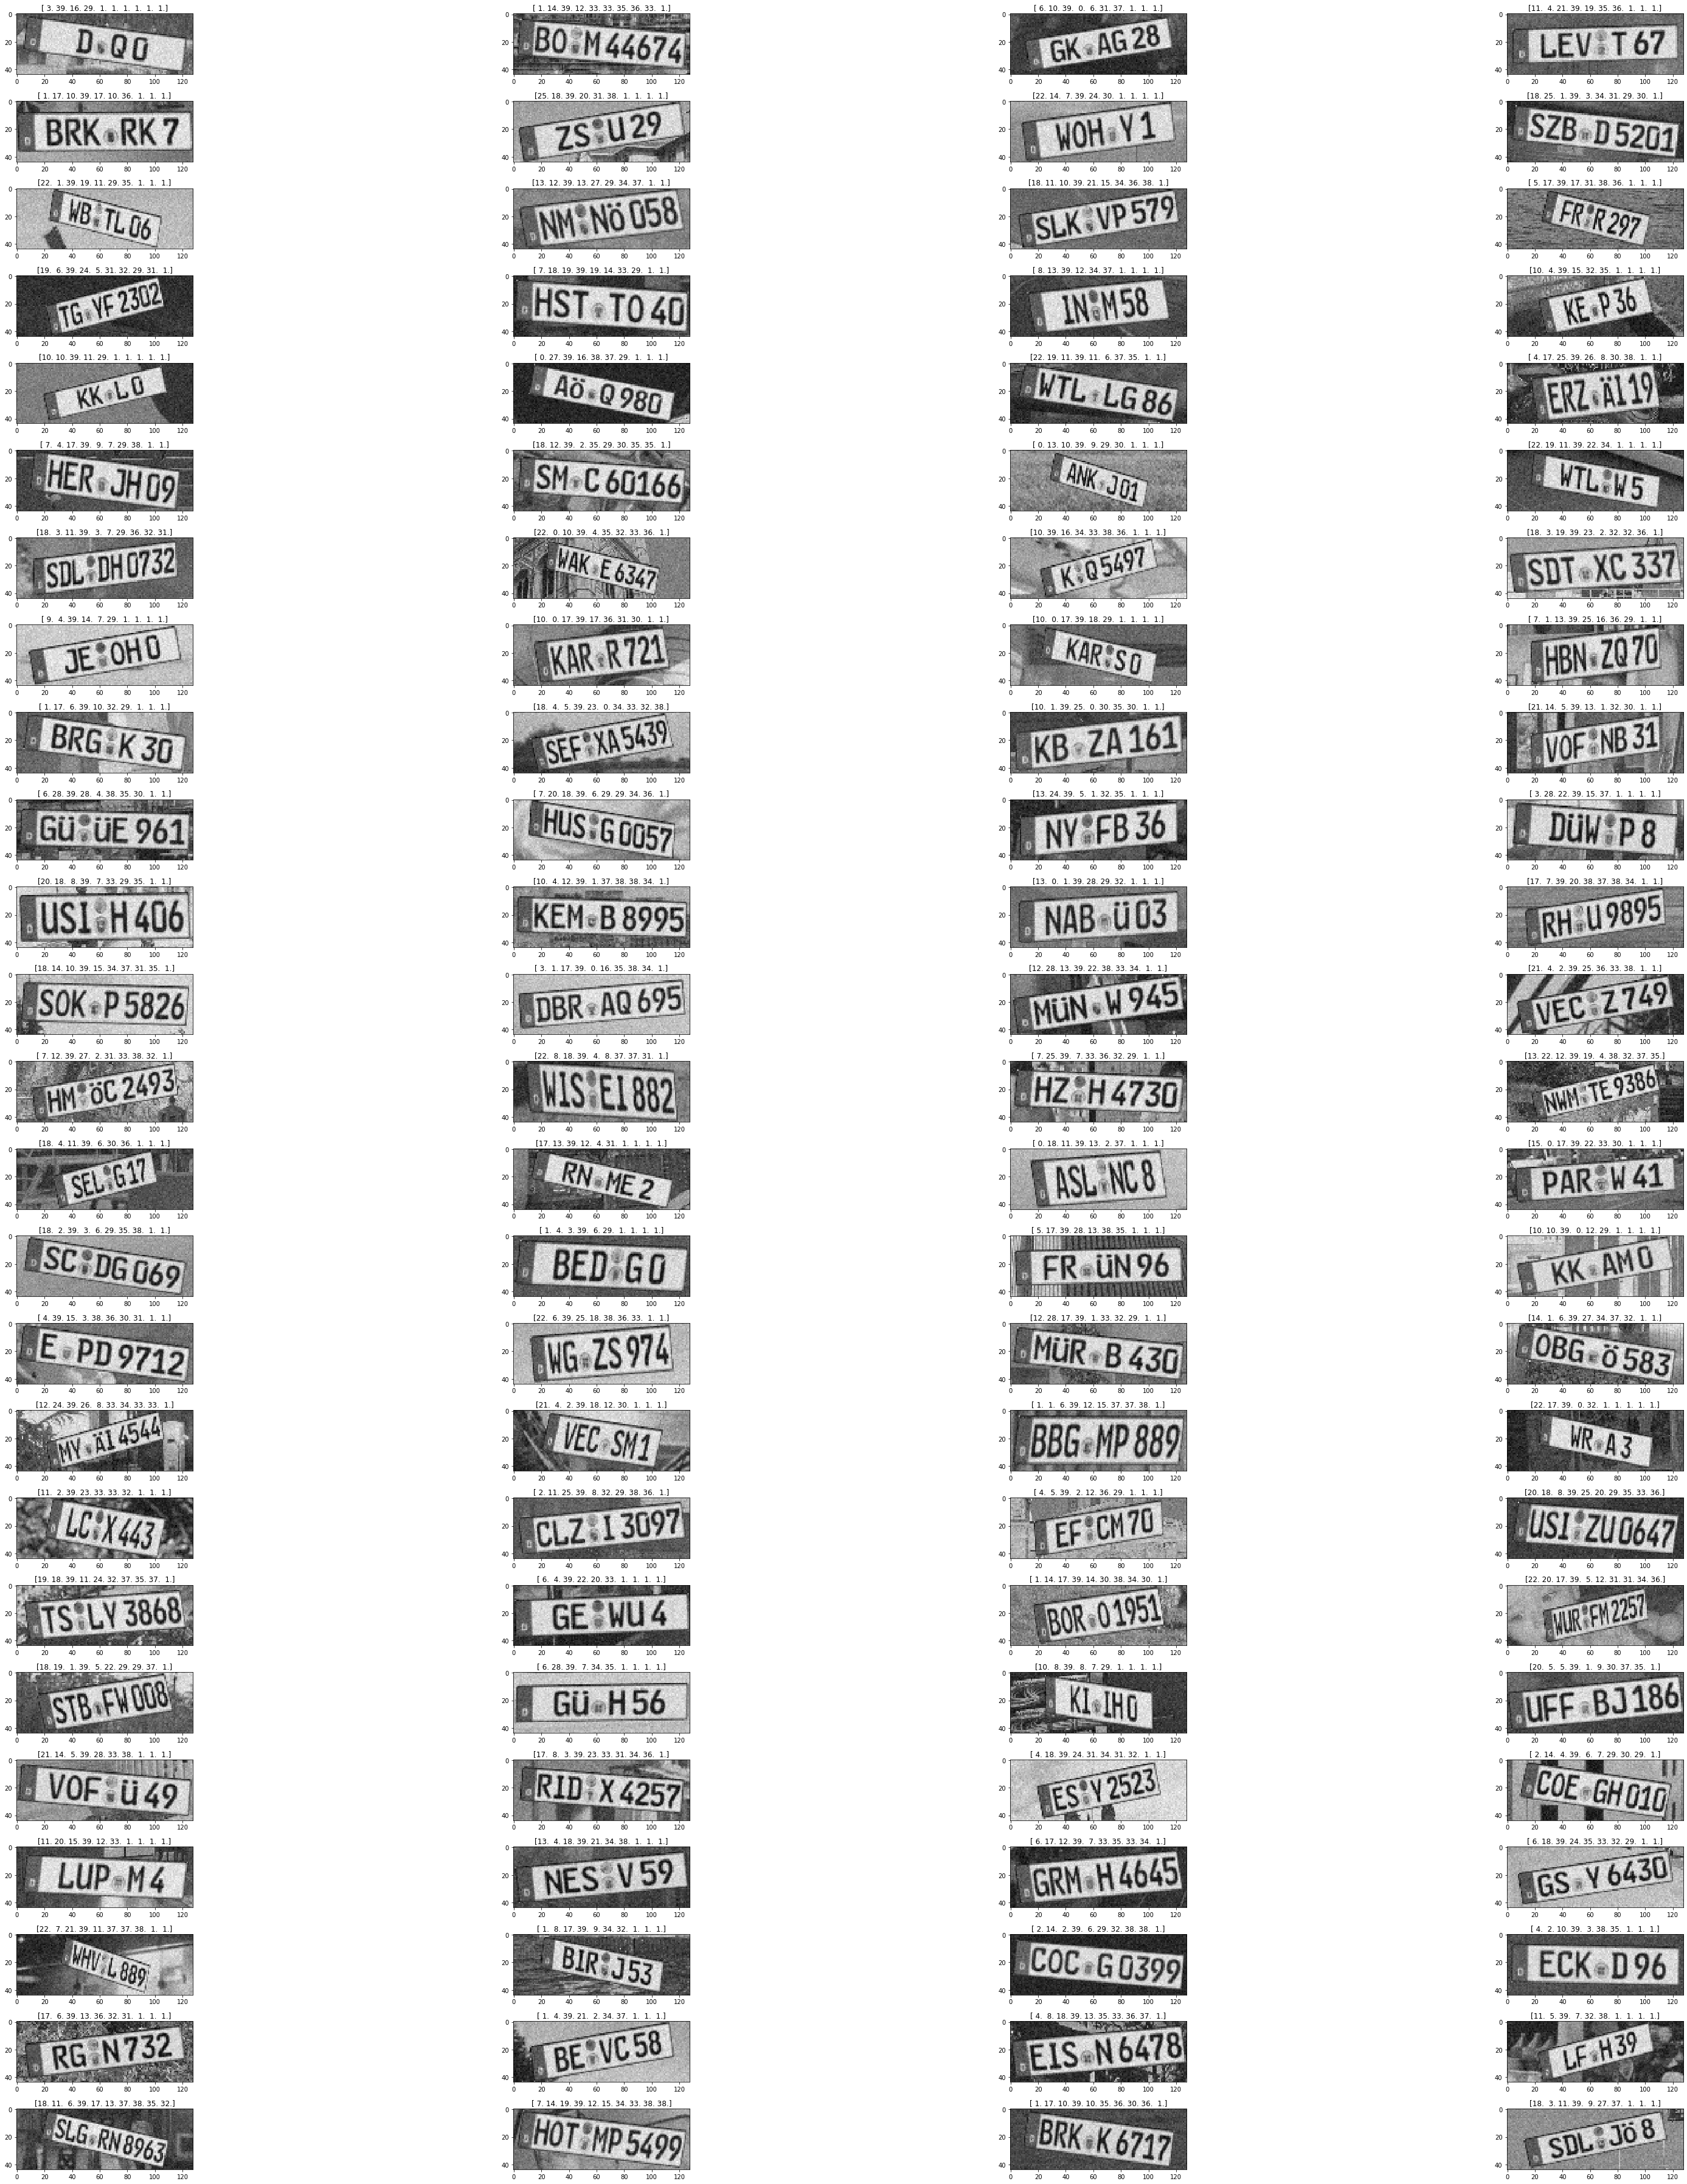

In [4]:
from pyimagesearch.io import Hdf5DatasetLoader
from license_plate_image_augmentor import LicensePlateImageAugmentor
from licence_plate_dataset_generator import LicensePlateDatasetGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from label_codec import LabelCodec
import skimage

loader = Hdf5DatasetLoader()
background_images = loader.load(data_path + '/hdf5/background.h5', shuffle=True, max_items=10000)
    
augmentor = LicensePlateImageAugmentor(IMAGE_WIDTH, IMAGE_HEIGHT, background_images)
train_generator = LicensePlateDatasetGenerator(X_train, y_train, IMAGE_WIDTH, IMAGE_HEIGHT,
                                               POOL_SIZE, MAX_TEXT_LEN, BATCH_SIZE, augmentor)

val_generator = LicensePlateDatasetGenerator(X_test, y_test, IMAGE_WIDTH, IMAGE_HEIGHT,
                                             POOL_SIZE, MAX_TEXT_LEN, BATCH_SIZE, augmentor)

inputs, outputs = next(train_generator.generator())

def plotImages(images_arr, labels, rows, columns):
    fig, axes = plt.subplots(rows, columns, figsize=(50,50))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels, axes):
        img = img.T.reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
        ax.set_title(label)
        ax.imshow(img, cmap='gray')
    plt.tight_layout()
    plt.show()
        
plotImages(inputs["input"], inputs["labels"], int(BATCH_SIZE / 4), 4)

### Create the CNN

In [5]:
from tensorflow.python.keras import Input
from tensorflow.python.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from pyimagesearch.nn.conv import OCR
from label_codec import LabelCodec

def get_optimizer(optimizer):
    if optimizer == "sdg":
        return SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    if optimizer == "rmsprop":
        return RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    if optimizer == "adam":
        return Adam(lr=0.001, decay=0.001 / config.NUM_EPOCHS)
        # Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    if optimizer == "adagrad":
        return Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
    if optimizer == "adadelta":
        return Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
    
class CTCLoss(tf.keras.losses.Loss):

    def __init__(self, input_length, label_length, name='CTCLoss'):
        super().__init__(name=name)
        self.input_length = input_length
        self.label_length = label_length

    def call(self, labels, predictions):
        loss = tf.keras.backend.ctc_batch_cost(labels, predictions, self.input_length, self.label_length)
        loss = tf.reduce_mean(loss)
        return loss

tf.compat.v1.disable_eager_execution()

labels = Input(name='labels', shape=(MAX_TEXT_LEN,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64')

inputs, predictions = OCR.build((IMAGE_WIDTH, IMAGE_HEIGHT, 1), POOL_SIZE, len(LabelCodec.ALPHABET) + 1)

train_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=predictions)
train_model.add_loss(CTCLoss(input_length, label_length)(labels, predictions))
train_model.compile(loss=None, optimizer=get_optimizer(OPTIMIZER), metrics=['loss'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Andreas\Anaconda3\envs\dl4cv\lib\site-packages\IPython\core\interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-ff1cb80c5d8c>", line 42, in <module>
    train_model.compile(loss=None, optimizer=get_optimizer(OPTIMIZER), metrics=['loss'])
  File "C:\Users\Andreas\Anaconda3\envs\dl4cv\lib\site-packages\tensorflow_core\python\training\tracking\base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "C:\Users\Andreas\Anaconda3\envs\dl4cv\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 429, in compile
    self._cache_output_metric_attributes(metrics, weighted_metrics)
  File "C:\Users\Andreas\Anaconda3\envs\dl4cv\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 1842, in _cache_output_metric_attributes
    metrics, self.output_names, output_shapes, self.loss_functions)
  File "C:\Users\And

ValueError: Unknown metric function:loss

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pyimagesearch.callbacks import CustomModelCheckpoint

def get_callbacks(output_path, optimizer_method, model_name):
    model_checkpoint_path = os.path.sep.join([output_path, optimizer_method, model_name]) + '.h5'
    
    callbacks = [
        EarlyStopping(monitor='loss', min_delta=0.01, patience=5, mode='min', verbose=1),
        CustomModelCheckpoint(model_to_save=model, filepath=model_checkpoint_path, monitor='loss', verbose=1, save_best_only=True, mode='min', period=1),
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.01, cooldown=0, min_lr=0)]
    return callbacks

In [35]:
history = model.fit_generator(
    train_generator.generator(),
    steps_per_epoch=train_generator.numImages // BATCH_SIZE,
    validation_data=val_generator.generator(),
    validation_steps=val_generator.numImages // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=get_callbacks(OUTPUT_PATH, OPTIMIZER, MODEL_NAME), verbose=1)

Epoch 1/100
521/522 [============================>.] - ETA: 0s - loss: 23.0016 - accuracy: 0.0000e+00- ETA: 1s - loss: 23.0020 - accuracy: 0.00
Epoch 00001: loss improved from inf to 22.99957, saving model to output\adagrad\alpr.model.h5
522/522 [==============================] - 119s 228ms/step - loss: 22.9996 - accuracy: 0.0000e+00 - val_loss: 22.7039 - val_accuracy: 0.0000e+00
Epoch 2/100
521/522 [============================>.] - ETA: 0s - loss: 22.5174 - accuracy: 0.0000e+00
Epoch 00002: loss improved from 22.99957 to 22.51650, saving model to output\adagrad\alpr.model.h5
522/522 [==============================] - 120s 229ms/step - loss: 22.5165 - accuracy: 0.0000e+00 - val_loss: 22.4006 - val_accuracy: 0.0000e+00
Epoch 3/100
521/522 [============================>.] - ETA: 0s - loss: 22.2645 - accuracy: 0.0000e+00- ETA: 4s - loss: 22.27 - ETA: 0s - loss: 22.2646 - accuracy: 0.0000e+00
Epoch 00003: loss improved from 22.51650 to 22.26438, saving model to output\adagrad\alpr.model.h

Epoch 24/100
521/522 [============================>.] - ETA: 0s - loss: 6.8984 - accuracy: 1.9194e-05
Epoch 00024: loss improved from 7.56496 to 6.89650, saving model to output\adagrad\alpr.model.h5
522/522 [==============================] - 120s 229ms/step - loss: 6.8965 - accuracy: 1.9157e-05 - val_loss: 6.5054 - val_accuracy: 1.5385e-04
Epoch 25/100
521/522 [============================>.] - ETA: 0s - loss: 6.2855 - accuracy: 2.3033e-04
Epoch 00025: loss improved from 6.89650 to 6.28505, saving model to output\adagrad\alpr.model.h5
522/522 [==============================] - 120s 229ms/step - loss: 6.2850 - accuracy: 2.2989e-04 - val_loss: 6.0677 - val_accuracy: 6.1538e-04
Epoch 26/100
521/522 [============================>.] - ETA: 0s - loss: 5.6969 - accuracy: 5.7582e-04
Epoch 00026: loss improved from 6.28505 to 5.69667, saving model to output\adagrad\alpr.model.h5
522/522 [==============================] - 119s 229ms/step - loss: 5.6967 - accuracy: 5.7471e-04 - val_loss: 5.3992 -

Epoch 49/100
521/522 [============================>.] - ETA: 0s - loss: 0.9888 - accuracy: 0.5512
Epoch 00049: loss improved from 1.04126 to 0.98891, saving model to output\adagrad\alpr.model.h5
522/522 [==============================] - 118s 225ms/step - loss: 0.9889 - accuracy: 0.5513 - val_loss: 0.9995 - val_accuracy: 0.5462
Epoch 50/100
521/522 [============================>.] - ETA: 0s - loss: 0.9474 - accuracy: 0.5753
Epoch 00050: loss improved from 0.98891 to 0.94712, saving model to output\adagrad\alpr.model.h5
522/522 [==============================] - 118s 226ms/step - loss: 0.9471 - accuracy: 0.5755 - val_loss: 0.9387 - val_accuracy: 0.5625
Epoch 51/100
521/522 [============================>.] - ETA: 0s - loss: 0.8689 - accuracy: 0.6035
Epoch 00051: loss improved from 0.94712 to 0.86894, saving model to output\adagrad\alpr.model.h5
522/522 [==============================] - 119s 229ms/step - loss: 0.8689 - accuracy: 0.6036 - val_loss: 0.8950 - val_accuracy: 0.6077
Epoch 52/1

Epoch 74/100
521/522 [============================>.] - ETA: 0s - loss: 0.3769 - accuracy: 0.8477
Epoch 00074: loss improved from 0.39122 to 0.37671, saving model to output\adagrad\alpr.model.h5
522/522 [==============================] - 117s 225ms/step - loss: 0.3767 - accuracy: 0.8478 - val_loss: 0.3743 - val_accuracy: 0.8448
Epoch 75/100
521/522 [============================>.] - ETA: 0s - loss: 0.3658 - accuracy: 0.8539
Epoch 00075: loss improved from 0.37671 to 0.36594, saving model to output\adagrad\alpr.model.h5
522/522 [==============================] - 119s 228ms/step - loss: 0.3659 - accuracy: 0.8538 - val_loss: 0.3868 - val_accuracy: 0.8489
Epoch 76/100
521/522 [============================>.] - ETA: 0s - loss: 0.3582 - accuracy: 0.8574
Epoch 00076: loss improved from 0.36594 to 0.35809, saving model to output\adagrad\alpr.model.h5
522/522 [==============================] - 117s 225ms/step - loss: 0.3581 - accuracy: 0.8574 - val_loss: 0.3796 - val_accuracy: 0.8504
Epoch 77/1